In [1]:
import requests

def download_file(url, target_path):
  try:
    response = requests.get(url)
    response.raise_for_status()
    with open(target_path, "wb")as f:
      f.write(response.content)
    print(f"Downloaded file {target_path}")
  except requests.exceptions.RequestException as e:
    print(f"Failed to Download {url}. Error: {e}")

files_to_download = [
    ('https://raw.githubusercontent.com/galeajua/coffee-brewer/master/data/arabica_raw.csv', 'arabica_raw.csv'),
    ('https://raw.githubusercontent.com/galeajua/coffee-brewer/master/data/cotter_dataset.csv', 'cotter.csv')
]

for url, path in files_to_download:
  download_file(url, path)


Downloaded file arabica_raw.csv
Downloaded file cotter.csv


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway


In [4]:
# Load Data
arabica_data = pd.read_csv('arabica_raw.csv')
cotter_data = pd.read_csv('cotter.csv')

In [5]:
# Basic Info
print("Arabica Dataset:")
arabica_data.info()
print("\nCotter Dataset:")
cotter_data.info()

Arabica Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312 entries, 0 to 1311
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        1312 non-null   int64  
 1   quality_score                     1312 non-null   float64
 2   view_certificate_1                0 non-null      float64
 3   view_certificate_2                0 non-null      float64
 4   Cupping Protocol and Descriptors  0 non-null      float64
 5   View Green Analysis Details       0 non-null      float64
 6   Request a Sample                  0 non-null      float64
 7   Species                           1312 non-null   object 
 8   Owner                             1305 non-null   object 
 9   Country of Origin                 1311 non-null   object 
 10  Farm Name                         956 non-null    object 
 11  Lot Number                        270 non-null    ob

In [6]:
# Sizes
print(f"The Arabica Dataset has a length of {len(arabica_data)} and a shape of {arabica_data.shape}")
print(f"The Cotter Dataset has a length of {len(cotter_data)} and a shape of {cotter_data.shape}")

The Arabica Dataset has a length of 1312 and a shape of (1312, 53)
The Cotter Dataset has a length of 3186 and a shape of (3186, 48)


In [7]:
# Einblick in die ersten paar Zeilen beider Datensätze
pd.set_option("display.max.columns", None)
print("\nArabica Dataset:\n")
print(arabica_data.head())
print("\n")
print("\n")
print("\nCotter Dataset:\n")
print("\n")
print("\n")
print(cotter_data.head())


Arabica Dataset:

   Unnamed: 0  quality_score  view_certificate_1  view_certificate_2  \
0           0          90.58                 NaN                 NaN   
1           1          89.92                 NaN                 NaN   
2           2          89.75                 NaN                 NaN   
3           3          89.00                 NaN                 NaN   
4           4          88.83                 NaN                 NaN   

   Cupping Protocol and Descriptors  View Green Analysis Details  \
0                               NaN                          NaN   
1                               NaN                          NaN   
2                               NaN                          NaN   
3                               NaN                          NaN   
4                               NaN                          NaN   

   Request a Sample  Species                     Owner Country of Origin  \
0               NaN  Arabica                 metad plc         


Arabica Dataset Summary Statistics:

        Unnamed: 0  quality_score  view_certificate_1  view_certificate_2  \
count  1312.000000    1312.000000                 0.0                 0.0   
mean    655.309451      82.086212                 NaN                 NaN   
std     378.860186       3.675542                 NaN                 NaN   
min       0.000000       0.000000                 NaN                 NaN   
25%     327.750000      81.170000                 NaN                 NaN   
50%     655.500000      82.500000                 NaN                 NaN   
75%     983.250000      83.670000                 NaN                 NaN   
max    1310.000000      90.580000                 NaN                 NaN   

       Cupping Protocol and Descriptors  View Green Analysis Details  \
count                               0.0                          0.0   
mean                                NaN                          NaN   
std                                 NaN             

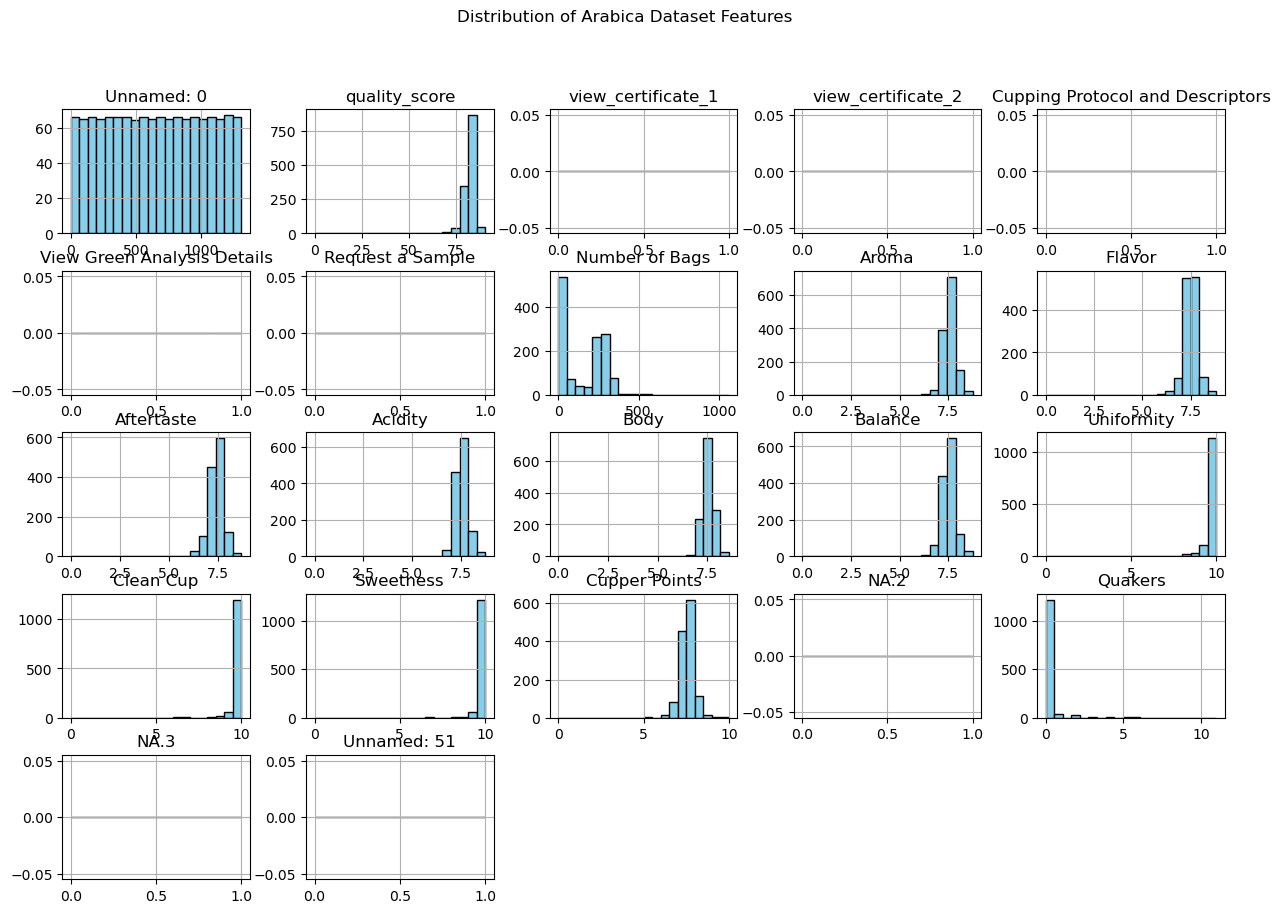

In [8]:
# Summary & Missing Values Arabica
print("\nArabica Dataset Summary Statistics:\n")
print(arabica_data.describe())
print("\nMissing Values in Arabica Dataset:\n")
print(arabica_data.isnull().sum())

# Distribution Arabica
arabica_data.hist(figsize=(15, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Arabica Dataset Features")
plt.show()

In [9]:
# Um sinnvolle Hypothesentest und beispielsweise Heatmaps darstellen zu können, müssen wir den Arabica-Datensatz ein erstes Mal
# bereinigen.

# Verwerfung von Spalten die wir sicher nicht verwenden werden (aufgrund von bspw. laueter null-values)
drop_columns_arabica = ['Unnamed: 0', 'view_certificate_1', 'view_certificate_2',
                   'Cupping Protocol and Descriptors', 'View Green Analysis Details',
                   'Request a Sample', 'Lot Number', 'Mill', 'ICO Number',
                   'Number of Bags', 'Bag Weight', 'In-Country Partner',
                   'Status', 'NA', 'NA.1', 'NA.2', 'Category One Defects',
                   'Quakers', 'Category Two Defects', 'NA.3', 'Expiration',
                   'Certification Body', 'Certification Address', 'Certification Contact',
                   'Unnamed: 51', 'Notes', 'Owner', 'Owner.1', 'Region', 'Producer',
                   'Company', 'Farm Name', 'Harvest Year', 'Grading Date']

arabica_data = arabica_data.drop(columns=drop_columns_arabica)

In [10]:
# um die Spalte 'Altitude' nutzen zu können, müssen wir die Werte standardisieren. Dazu werden wir jeweils den numerischen Wert extrahieren
# (in Meter) und setzen bei zwei Werten (Ober- und Untergrenze) den Durchschnitt beider Werte
def clean_altitude(altitude):

    if pd.isnull(altitude):
        return None
    
    numbers = re.findall(r'\d+\.?\d*', altitude)
    if numbers:
        numbers = [float(num) for num in numbers]
        return sum(numbers) / len(numbers) if len(numbers) > 1 else numbers[0]
    return None


arabica_data['Altitude'] = arabica_data['Altitude'].apply(clean_altitude)


In [11]:
# Um Situationen zu handhaben, in denen bspw. Interpunktion verwendet wird, um Kilometer statt Meter auszudrücken,
# setzen wir einen Threshold und multiplizieren wir * 1000 falls dieser überschritten wird
arabica_data['Altitude'] = arabica_data['Altitude'].apply(lambda x: x * 1000 if x < 10 else x)
arabica_data.rename(columns={'Altitude': 'Altitude (m)', 'quality_score': 'score'})

,score,Species,Country of Origin,Altitude (m),Variety,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Cupper Points,Total Cup Points,Moisture,Color
0,90.58,Arabica,Ethiopia,2075.0,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.00,10.00,10.00,8.75,Sample 90.58,12 %,Green
1,89.92,Arabica,Ethiopia,2075.0,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.00,10.00,10.00,8.58,Sample 89.92,12 %,Green
2,89.75,Arabica,Guatemala,1700.0,Bourbon,NaN,8.42,8.50,8.42,8.42,8.33,8.42,10.00,10.00,10.00,9.25,Sample 89.75,0 %,NaN
3,89.00,Arabica,Ethiopia,2000.0,NaN,Natural / Dry,8.17,8.58,8.42,8.42,8.50,8.25,10.00,10.00,10.00,8.67,Sample 89.00,11 %,Green
4,88.83,Arabica,Ethiopia,2075.0,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.00,10.00,10.00,8.58,Sample 88.83,12 %,Green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,67.92,Arabica,Haiti,350.0,Typica,Natural / Dry,6.75,6.58,6.42,6.67,7.08,6.67,9.33,6.00,6.00,6.42,Sample 67.92,14 %,Blue-Green
1308,63.08,Arabica,Nicaragua,1100.0,Caturra,Other,7.25,6.58,6.33,6.25,6.42,6.08,6.00,6.00,6.00,6.17,Sample 63.08,13 %,Green
1309,59.83,Arabica,Guatemala,4650.0,Catuai,Washed / Wet,7.50,6.67,6.67,7.67,7.33,6.67,8.00,1.33,1.33,6.67,Sample 59.83,10 %,Green
1310,43.13,Arabica,Ethiopia,NaN,NaN,NaN,6.00,6.00,6.25,6.88,6.00,6.00,0.00,0.00,0.00,6.00,Sample 43.13,0 %,NaN


In [12]:
# handhabung der Spalten 'Total Cup Points' und 'Moisture'
arabica_data['Total Cup Points'] = arabica_data['Total Cup Points'].str.extract(r'(\d+\.\d+)')

# verwandle bspw. den Wert '12 %' zu 0.12
arabica_data['Moisture'] = arabica_data['Moisture'].str.replace('%', '').astype(float) / 100
arabica_data.rename(columns={'Moisture': 'Moisture (%)'})

,quality_score,Species,Country of Origin,Altitude,Variety,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Cupper Points,Total Cup Points,Moisture (%),Color
0,90.58,Arabica,Ethiopia,2075.0,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.00,10.00,10.00,8.75,90.58,0.12,Green
1,89.92,Arabica,Ethiopia,2075.0,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.00,10.00,10.00,8.58,89.92,0.12,Green
2,89.75,Arabica,Guatemala,1700.0,Bourbon,NaN,8.42,8.50,8.42,8.42,8.33,8.42,10.00,10.00,10.00,9.25,89.75,0.00,NaN
3,89.00,Arabica,Ethiopia,2000.0,NaN,Natural / Dry,8.17,8.58,8.42,8.42,8.50,8.25,10.00,10.00,10.00,8.67,89.00,0.11,Green
4,88.83,Arabica,Ethiopia,2075.0,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.00,10.00,10.00,8.58,88.83,0.12,Green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,67.92,Arabica,Haiti,350.0,Typica,Natural / Dry,6.75,6.58,6.42,6.67,7.08,6.67,9.33,6.00,6.00,6.42,67.92,0.14,Blue-Green
1308,63.08,Arabica,Nicaragua,1100.0,Caturra,Other,7.25,6.58,6.33,6.25,6.42,6.08,6.00,6.00,6.00,6.17,63.08,0.13,Green
1309,59.83,Arabica,Guatemala,4650.0,Catuai,Washed / Wet,7.50,6.67,6.67,7.67,7.33,6.67,8.00,1.33,1.33,6.67,59.83,0.10,Green
1310,43.13,Arabica,Ethiopia,NaN,NaN,NaN,6.00,6.00,6.25,6.88,6.00,6.00,0.00,0.00,0.00,6.00,43.13,0.00,NaN


In [ ]:
# Speichern des bereinigten Arabica-Datensazes
try:
    target_path = '../../data/arabica_clean.csv'
    arabica_data.to_csv(target_path, index=False)
    print(f"save file in directory: {target_path}")
except Exception as e:
    print(f"Failed to save the DataFrame. Error: {e}")